In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model,Sequential,load_model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import  MinMaxScaler ,StandardScaler
import math
from sklearn.metrics import mean_squared_error ,accuracy_score
from pickle import dump, load
from math import sqrt
from tensorflow.keras.optimizers import SGD ,RMSprop

In [28]:
print(tf.__version__)

2.4.1


In [29]:
col_names =['sl_no','iteration','r_meas','phi_meas','rr_meas','x_m','y_m','dx_m','dy_m','r_gd','phi_gd','rr_gd','x_gd','y_gd','dx_gd','dy_gd']

In [30]:
 df= pd.read_csv("data/training_data.csv",names=col_names,header=None)

In [31]:
df.head()

,sl_no,iteration,r_meas,phi_meas,rr_meas,x_m,y_m,dx_m,dy_m,r_gd,phi_gd,rr_gd,x_gd,y_gd,dx_gd,dy_gd
0,1,0,13.661716,0.006404,-0.176324,13.661436,0.087489,-0.176320,-0.001129,8.857460,0.000044,0.000746,8.857460,0.000391,0.000746,0.000000
1,1,1,18.462030,-0.017085,0.050058,18.459336,-0.315405,0.050051,-0.000855,8.825450,0.000429,-0.032009,8.825450,0.003786,-0.032009,-0.000014
2,1,2,6.413294,0.005260,0.005861,6.413205,0.033733,0.005861,0.000031,8.815560,0.001020,-0.009891,8.815555,0.008991,-0.009891,-0.000010
3,1,3,1.603305,-0.006222,0.035707,1.603274,-0.009976,0.035707,-0.000222,8.905530,0.001560,0.089970,8.905519,0.013895,0.089970,0.000140
4,1,4,7.389476,-0.015556,0.308614,7.388582,-0.114947,0.308577,-0.004801,9.140382,0.002096,0.234852,9.140361,0.019157,0.234851,0.000492


In [32]:
data = df[['x_m','y_m','x_gd','y_gd']]
data_input = data[['x_m','y_m']].values
data_input = data_input.reshape(-1,2)
data_gd = data[['x_gd','y_gd']].values
data_gd = data_gd.reshape(-1,2)

In [33]:
data_input.shape

(86254, 2)

In [34]:
#scaler_input_trail = MinMaxScaler()
#data_input_norm = scaler_input_trail.fit_transform(data_input)
#scaler_output_trail = MinMaxScaler()
#data_gd_norm = scaler_output_trail.fit_transform(data_gd)



In [35]:
def get_RMSE(predictions, ground_truth):
    x_rmse =sqrt(np.mean((predictions[:,0]-ground_truth[:,0])**2))
    y_rmse =sqrt(np.mean((predictions[:,1]-ground_truth[:,1])**2))
    return x_rmse,y_rmse
    

In [36]:
T=5
D=2
train_size = int(len(data_input)*0.75)

In [37]:
train_input , train_gd = data_input[:train_size] ,data_gd[:train_size]
print(f"training size input  {train_input.shape} , train size output {train_gd.shape}")

valid_input , valid_gd = data_input[train_size:] ,data_gd[train_size:]
print(f"test size input  {valid_input.shape} , test size output {valid_gd.shape}")



training size input  (64690, 2) , train size output (64690, 2)
test size input  (21564, 2) , test size output (21564, 2)


In [38]:
""" creates data sequences for input as well for the lables(output) 
    each row of this form isc created (x1,y1),(x2,y2),(x3.y3) --> (x_gd,y_gd)
    It contains the previous 3 measurements and ground truth of 4th element which is compared with prediction from model
""" 

def create_dataset(dataset_x,dataset_y,T):
    dataX, dataY = [], []
    for t in range(len(dataset_x)-T):
        x = dataset_x[t:t+T]
        dataX.append(x)
        dataY.append(dataset_y[t + T])
    return np.array(dataX), np.array(dataY)

In [39]:
train_input_seqs , train_gd_seq = create_dataset(train_input,train_gd,T)
valid_input_seqs , valid_gd_seq = create_dataset(valid_input,valid_gd,T)

train_input_seqs.shape

(64685, 5, 2)

In [40]:
adm =RMSprop(lr=0.001)
model_trail_u = Sequential()
model_trail_u.add(LSTM(16,input_shape=(T,2)))
#model_trail.add(LSTM(32))
model_trail_u.add(Dense(2))
model_trail_u.compile(loss ='mse',optimizer=adm)
rtu= model_trail_u.fit(train_input_seqs, train_gd_seq, epochs=200, batch_size = 32,verbose=2 ,validation_data=(valid_input_seqs,valid_gd_seq))


Epoch 1/200
2022/2022 - 17s - loss: 2058.7959 - val_loss: 1375.2843
Epoch 2/200
2022/2022 - 3s - loss: 1193.8042 - val_loss: 781.7631
Epoch 3/200
2022/2022 - 3s - loss: 706.5212 - val_loss: 449.8618
Epoch 4/200
2022/2022 - 3s - loss: 434.1822 - val_loss: 271.3522
Epoch 5/200
2022/2022 - 3s - loss: 284.4566 - val_loss: 176.5846
Epoch 6/200
2022/2022 - 3s - loss: 201.2500 - val_loss: 133.3051
Epoch 7/200
2022/2022 - 3s - loss: 154.9109 - val_loss: 103.8582
Epoch 8/200
2022/2022 - 3s - loss: 127.7998 - val_loss: 89.0905
Epoch 9/200
2022/2022 - 3s - loss: 110.8361 - val_loss: 80.2514
Epoch 10/200
2022/2022 - 3s - loss: 99.9404 - val_loss: 79.4102
Epoch 11/200
2022/2022 - 3s - loss: 91.8254 - val_loss: 65.9348
Epoch 12/200
2022/2022 - 3s - loss: 86.0383 - val_loss: 64.9416
Epoch 13/200
2022/2022 - 3s - loss: 82.0754 - val_loss: 60.8407
Epoch 14/200
2022/2022 - 3s - loss: 79.1172 - val_loss: 63.4576
Epoch 15/200
2022/2022 - 3s - loss: 76.3341 - val_loss: 60.8327
Epoch 16/200
2022/2022 - 3s -

Epoch 129/200
2022/2022 - 3s - loss: 60.7139 - val_loss: 50.8807
Epoch 130/200
2022/2022 - 3s - loss: 60.9273 - val_loss: 50.8761
Epoch 131/200
2022/2022 - 3s - loss: 60.6054 - val_loss: 53.0514
Epoch 132/200
2022/2022 - 3s - loss: 61.2609 - val_loss: 50.3621
Epoch 133/200
2022/2022 - 3s - loss: 61.1076 - val_loss: 58.0859
Epoch 134/200
2022/2022 - 3s - loss: 61.0376 - val_loss: 54.5347
Epoch 135/200
2022/2022 - 3s - loss: 60.9349 - val_loss: 52.5113
Epoch 136/200
2022/2022 - 3s - loss: 61.0185 - val_loss: 50.4518
Epoch 137/200
2022/2022 - 3s - loss: 61.3717 - val_loss: 51.5065
Epoch 138/200
2022/2022 - 3s - loss: 60.6889 - val_loss: 51.7758
Epoch 139/200
2022/2022 - 3s - loss: 60.5469 - val_loss: 53.0471
Epoch 140/200
2022/2022 - 3s - loss: 61.2197 - val_loss: 52.0871
Epoch 141/200
2022/2022 - 3s - loss: 61.1540 - val_loss: 51.1970
Epoch 142/200
2022/2022 - 3s - loss: 60.7710 - val_loss: 53.6044
Epoch 143/200
2022/2022 - 3s - loss: 60.9903 - val_loss: 52.1740
Epoch 144/200
2022/2022 -

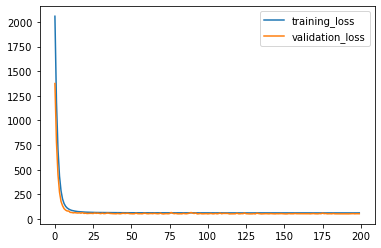

In [41]:
import matplotlib.pyplot as plt
plt.plot(rtu.history['loss'], label='training_loss')
plt.plot(rtu.history['val_loss'], label='validation_loss')
plt.legend()

In [85]:
#dump(model,open('model.pkl','wb'))
model_trail_u.save("more_trail_u")


INFO:tensorflow:Assets written to: more_trail_u\assets


INFO:tensorflow:Assets written to: more_trail_u\assets


In [14]:
model_trail_u= load_model("more_trail_u")

In [15]:
trainPredict = model_trail_u.predict(train_input_seqs)
ValidPredict = model_trail_u.predict(valid_input_seqs)


In [16]:
trainScore = math.sqrt(mean_squared_error(train_gd_seq, trainPredict))
print('Train Score: %.7f RMSE' % (trainScore))
ValidScore = math.sqrt(mean_squared_error(valid_gd_seq, ValidPredict))
print('Test Score: %.7f RMSE' % (ValidScore))


Train Score: 7.7629827 RMSE
Test Score: 7.2901418 RMSE


In [ ]:
# test data from same training file

In [25]:
df_TEST = pd.read_csv("data/testing_Data.csv",names=col_names,header=None)

df_TEST.head()


,sl_no,iteration,r_meas,phi_meas,rr_meas,x_m,y_m,dx_m,dy_m,r_gd,phi_gd,rr_gd,x_gd,y_gd,dx_gd,dy_gd
0,1,0.0,118.557733,0.003044,0.255106,118.557184,0.360887,0.255105,0.000777,122.163476,0.000031,0.303078,122.163476,0.003750,0.303078,0.000009
1,1,1.0,120.571556,-0.003406,0.063379,120.570856,-0.410665,0.063379,-0.000216,122.204948,0.000288,0.041473,122.204943,0.035176,0.041473,0.000012
2,1,2.0,118.427954,-0.005077,-0.154127,118.426428,-0.601236,-0.154125,0.000782,122.027939,0.000666,-0.177010,122.027912,0.081260,-0.177010,-0.000118
3,1,3.0,121.466013,0.011516,-0.271541,121.457960,1.398717,-0.271523,-0.003127,121.755473,0.001147,-0.272466,121.755392,0.139696,-0.272466,-0.000313
4,1,4.0,125.982723,0.004073,-0.338679,125.981678,0.513099,-0.338677,-0.001379,121.501160,0.001774,-0.254313,121.500969,0.215603,-0.254312,-0.000451


In [26]:
df_TEST.shape

(101101, 16)

In [19]:
data_TEST = df_TEST[['x_m','y_m','x_gd','y_gd']]
data_input_TEST = data_TEST[['x_m','y_m']].values
data_input_TEST = data_input_TEST.reshape(-1,2)
data_gd_TEST = data_TEST[['x_gd','y_gd']].values
data_gd_TEST= data_gd_TEST.reshape(-1,2)
data_gd_TEST.shape 

(101101, 2)

In [20]:
TEST_input_seqs ,TEST_output_seqs = create_dataset(data_input_TEST,data_gd_TEST,T)

In [21]:
predicts = model_trail_u.predict(TEST_input_seqs)

rmse_p :7.031107304378758 
rmse_m:3.8957378940889384


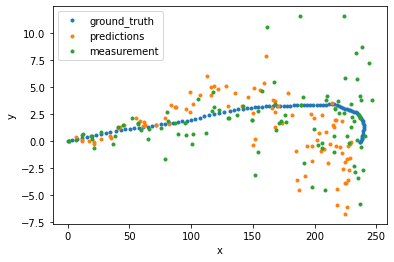

In [50]:
i=85
predict_b=predicts[(i*101):((i+1)*101)-T]
test_input_for_meas = data_input_TEST[(i*101)+T:(((i+1)*101))]
test_gd_for_meas_b = data_gd_TEST[(i*101)+T:(((i+1)*101))] 
plt.plot(test_gd_for_meas_b[:,0],test_gd_for_meas_b[:,1],'.')
plt.plot(predict_b[:,0],predict_b[:,1],'.')
plt.plot(test_input_for_meas[:,0],test_input_for_meas[:,1],'.')
plt.legend(["ground_truth","predictions","measurement"])
plt.xlabel("x")
plt.ylabel("y")
rmse_p = math.sqrt(mean_squared_error(predict_b, test_gd_for_meas_b))
print(f"rmse_p :{rmse_p} ")
rmse_m = math.sqrt(mean_squared_error(test_input_for_meas,test_gd_for_meas_b))
print(f"rmse_m:{rmse_m}")

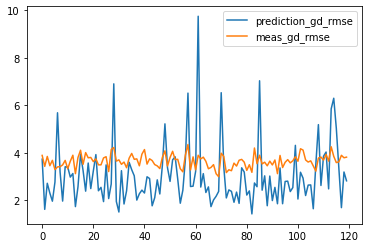

In [31]:

all_rmse_p =[]
all_rmse_m =[]

predicts = model_trail_u.predict(TEST_input_seqs)

for i in range(0,120):
    predict_b=predicts[(i*101):((i+1)*101)-T]
    test_input_for_meas = data_input_TEST[(i*101)+T:(((i+1)*101))]
    test_gd_for_meas_b = data_gd_TEST[(i*101)+T:(((i+1)*101))]    
    
    rmse_p = math.sqrt(mean_squared_error(predict_b, test_gd_for_meas_b))
    rmse_m = math.sqrt(mean_squared_error(test_input_for_meas,test_gd_for_meas_b))
                       
    all_rmse_p.append(rmse_p)
    all_rmse_m.append(rmse_m)
    
plt.plot(all_rmse_p)
plt.plot(all_rmse_m)
plt.legend(["prediction_gd_rmse","meas_gd_rmse"])

In [32]:
all_rmse_p_a = np.array(all_rmse_p)
all_rmse_m_a = np.array(all_rmse_m)


In [33]:
f=np.array((all_rmse_p_a-all_rmse_m_a)<0)

In [34]:
np.count_nonzero(f)

102